The [negative binomial distribution](http://en.wikipedia.org/wiki/Negative_binomial_distribution) crops up a lot in computational biology, and in particular RNA-sequencing analysis. In an ideal world we might expect the distribution of RNA-seq reads to be poisson, where the variance equals the mean and the only error comes from sampling alone. However, RNA-seq reads typically display more dispersion than this, which makes the negative binomial (NB) distribution a good choice since it can be thought of as an overdispersed poisson (or a poisson with a gamma-distributed rate). 

Here we consider Bayesian negative binomial regression of the form

$$ y_i \, \; | \, \; \beta_0, \beta_1, x_i, r \sim NB(\mu_i = \beta_0 + \beta_1 x_i, r) $$

where \\(r\\) is known as the _dispersion_ parameter, since the variance may be written as \\( Var(y_i) = \mu_i + \frac{\mu_i^2}{r} \\). We will implement bayesian inference using metropolis-hastings with the parameters \\(\beta_0 = 10\\), \\(\beta_1 = 5\\) and \\(r = 10 \\).

In [4]:
""" some setup """

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.stats import truncnorm
import seaborn as sns
%matplotlib inline

sns.set_palette("hls", desat=.6)
sns.set_context(rc={"figure.figsize": (6, 4)})
np.random.seed(123)

### A brief recap of Metropolis-Hastings and approximate inference

Parameter inference in a Bayesian setting is often concerned with estimating some posterior density \\(p(x)\\). However, if the prior and likelihood are not conjugate to each other then there is no closed-form solution for the posterior as the normalisation factor is intractable. Here the posterior distribution takes the form \\(p(x) = p^\star(x)/Z\\), where we can easily compute \\( p^\star(x) \\) but not \\(Z\\).

In such cases we can use the _Metropolis-Hastings_ algorithm. This builds up a Markov-chain of the variable \\(x\\), the samples of which converge towards the posterior distribution of \\(p(x)\\). It works as follows:

 1. Sample \\(x^\star\\) from the proposal distribution \\( q(x^\star ) \\). This is typically a Gaussian distribution centred around \\(x\\).
    ```
    x_star, y_star = np.array([x, y]) + np.random.normal(size=2,scale=0.001)
    ```
    > the sale parameter of the gaussian is very important and has to be tuned to have a good chain.
 2. Compute the _acceptance ratio_ 
$$ \alpha = \frac{p(x^\star)q(x | x^\star)}{p(x)q(x^\star|x)} $$
which is essentially the ratio of the probabilities of \\(x^\star\\) to \\(x\\) normalised by the probability of being there in the first place (i.e. the ratio of \\(q\\)). This last point is important as it is easy to get this the wrong way round.
  > if $q$ is symetric then $\alpha = \frac{p(x^\star)}{p(x)}$
  We can also use the log:
  $$
  \log \alpha = \log p(x^\star)   -\log p(x)  
  $$
 3. Accept \\(x^\star\\) as the next sample in the Markov chain with probability \\( \mathrm{min}(1, \alpha ) \\), otherwise use \\(x\\). In other words, if \\(x'\\) is more probable then always accept it, and even if it is less probable still accept it with probability \\( \alpha \\).
 

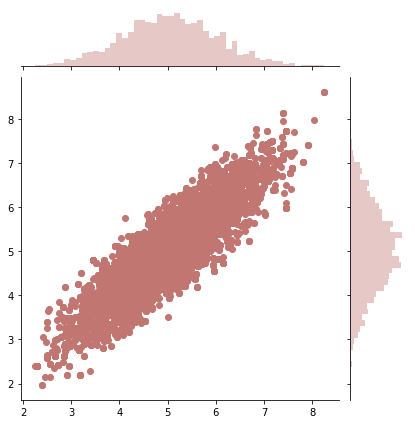

In [5]:
import numpy as np
import scipy.stats as st
import seaborn as sns


mus = np.array([5, 5])
sigmas = np.array([[1, .9], [.9, 1]])
 


def pgauss(x, y):
    return st.multivariate_normal.pdf([x, y], mean=mus, cov=sigmas)


def metropolis_hastings(p, iter=1000):
    x, y = 0., 0.
    samples = np.zeros((iter, 2))

    for i in range(iter):
        x_star, y_star = np.array([x, y]) + np.random.normal(size=2)
        alpha = p(x_star, y_star) / p(x, y)
        u = np.random.uniform()
        if u < alpha:
            x, y = x_star, y_star
        samples[i] = np.array([x, y])

    return samples
 
samples = metropolis_hastings(pgauss, iter=10000)
sns.jointplot(samples[50:, 0], samples[50:, 1])

### Poisson gamma distribution and negative binomial

#### The negative binomial

The neagative binomial $\text{NB}( r , p )$ in its classical definition has the following pmf:

$$
\operatorname { Pr } ( X = k ) = \left( \begin{array} { c } { k + r - 1 } \\ { k } \end{array} \right) \cdot ( 1 - p ) ^ { r } p ^ { k }
$$
The mean and var are give:
$$
\begin{array} { c } { \mathbb { E } ( X ) = \frac { p r } { ( 1 - p ) } \equiv \mu } \\ { \operatorname { Var } ( X ) = \frac { p r } { ( 1 - p ) ^ { 2 } } = \mu + \frac { 1 } { r } \mu ^ { 2 } } \end{array}
$$
Note that $\sigma^2\geq \mu$. 

As $r\rightarrow +\infty$ we get the Poisson distribution. That can also be seen as $\mu \rightarrow \sigma^2$. remeber that $X\sim \text{Poinsson}(\lambda)$ we have $P ( X = x ) = e ^ { - \lambda } \lambda ^ { x } / x !$

The negative binomial can be formulated with its mean and variance $\text{NB}(\mu,sigma^2 )$ making it usefull for regression. 

$$
\begin{array} { l } { p = \frac { \sigma ^ { 2 } - \mu } { \sigma ^ { 2 } } } =  \frac {\mu  } {  r+\mu} \\ { r = \frac { \mu ^ { 2 } } { \sigma ^ { 2 } - \mu } } \\ { \operatorname { Pr } ( X = k ) = \left( \begin{array} { c } { k + \frac { \mu ^ { 2 } } { \sigma ^ { 2 } - \mu } - 1 } \\ { k } \end{array} \right)  \left( \frac { \mu } { \sigma ^ { 2 } } \right) ^ { \mu ^ { 2 } / \left( \sigma ^ { 2 } - \mu \right) } }\left( \frac { \sigma ^ { 2 } - \mu } { \sigma ^ { 2 } } \right) ^ { k } \end{array}
$$

#### The poisson gamma

The Gamma distribution $\text{gamma}(\alpha,\beta)$ can be use for a prior of the Poisson distribution yielding:

$$
P ( X = k ) = \frac {  \beta ^ { \alpha } } { \Gamma ( \alpha ) } \int _ { 0 } ^ { \infty } \frac { e ^ { - \lambda } \lambda ^ { k } } { k ! } \lambda ^ { \alpha - 1 } e ^ { - \lambda \beta  } d \lambda
$$
with:
$$
\begin{array} { c } 
 \mathbb { E } ( X ) = \frac { \alpha } {\beta } \\
  \operatorname { Var } ( X ) = \frac { \alpha } {\beta^2 } \\ \end{array}
$$

A bit of algebra gives:

$$
\begin{aligned} & = \frac { \beta ^ { \alpha } } { k ! \Gamma ( \alpha )  } \int _ { 0 } ^ { \infty } \lambda ^ { \alpha + k - 1 } e ^ { - \lambda ( 1  + \beta ) } d \lambda \\ & = \frac { \beta ^ { \alpha } } { \Gamma ( k + 1 ) \Gamma ( \alpha )  } \Gamma ( \alpha + k ) \left( \frac {1 } { \beta + 1 } \right) ^ { \alpha + k } \\ & = \left( \begin{array} { c } {  k +\alpha    - 1 } \\ { k } \end{array} \right) \left( \frac {  \beta } { \beta + 1 } \right) ^ { \alpha } \left(  \frac { 1 } { \beta + 1 } \right) ^ { k }\\
&= \left( \begin{array} { c } {  k +\alpha    - 1 } \\ { k } \end{array} \right) (1-p) ^ { \alpha } p ^ { k }
\end{aligned}
$$

Therefore $r = \alpha$ and $p = 1/ ( \beta + 1 )$ and $\frac{\mu}{\sigma^2}=\frac{\beta}{\beta+1}$ and thus:

$$
\mu = \frac{\alpha}{\beta}
$$

### Metropolis Hasting Algorithm for glm

#### The glm model
Under the GLM framework we have $\mu =  w^\top x$ and $w\sim \mathcal{N}(0,I)$. Using Bayes we then obtain the posterior:
$$
P(w | \mathcal{D}) = \frac{P( \mathcal{D}|w )P(w )}{P( \mathcal{D})}
$$
removing the scaling factor and assuming $\mathcal{D} \sim\text{NB}(\mu,\sigma^2 )$ we can use the Bayesian version of the iterative re–weighted least squares fro estimation (West, 1985 and Gamerman, 1996).

The glm model general form is :

$$
P(Y=y) = \exp \left\{ \frac { y  \theta  - A \left( \theta  \right) } {  \sigma^2 } + c \left( y  , \sigma^2\right) \right\}
$$
Note that $E(Y) = A'(\theta)$ and $V(S) = A''(\theta)/\sigma^2$
We want positive mean so the link fuction is the the log;
$$
 w^\top x = \ln(\mu)
$$
The NB and the relationship $r=\alpha$ and $p$, thedistribution can be written as:
$$
\begin{aligned} 
&   P(Y=y) = \left( \begin{array} { c } {  y +\alpha   - 1 } \\ { y } \end{array} \right) (1-p) ^ { \alpha } p ^ { y }\\
& =\left( 
\begin{array} { c } {  y +\alpha  - 1 } \\ { y } 
\end{array} 
\right) 
\exp \left( \alpha \log (1-p)  + y \log (   p ) \right)\\
& =\left( 
\begin{array} { c } {  y +\alpha  - 1 } \\ { y } 
\end{array} 
\right) 
\exp \left( \alpha \log (1-\frac {\mu  } {  r+\mu})  + y \log (   \frac {\mu  } {  r+\mu} ) \right)\\
& =
\exp \left( r \log (\frac {r  } {  r+\mu})  + y \log (   \frac {\mu  } {  r+\mu} ) +\log\left( 
\begin{array} { c } {  y +r  - 1 } \\ { y } 
\end{array} 
\right) \right)
\end{aligned}
$$
html(http://www.chapmanhall.com/sc/sample/sc070106.pdf)

In comparison we have
the binomial regression $\mu = kp$ and 
    $P(Y=y) =\exp \left( k \log ( {  1-\mu})  + y \log (   \frac {\mu  } {  1-\mu} ) +\log\left( \begin{array} { c } {  k } \\ { y } \end{array} \right) \right)$
    
In comparison we have
the logistic regression $\mu = p$ and 
    $P(Y=y) =\exp \left(  \log ( {  1-\mu})  + y \log (   \frac {\mu  } {  1-\mu} ) +\log\left( \begin{array} { c } {  1 } \\ { y } \end{array} \right) \right)$

In [6]:
def nb_likelihood(r,mu,y):
    p = mu/(mu+r)
    return np.exp(r*np.log(1-p)+y*np.log(p)+np.log(scipy.special.binom(y+r-1, y)))

In [7]:
import scipy
from scipy.stats import nbinom
nb=nbinom(1,1-0.8333333333333334)
assert nb.pmf(2)==nb_likelihood(1,5,2)

Now the it is easy to derive the log likelihood. With $\mu = \exp(w^\top x)$ the function to optimise is then:
$$
P( \mathcal{D}|w ) \propto \exp\sum_i^n\left(y_iw^\top x_i- (y_i+r)\log(r+e^{w^\top x_i})))\right)
$$
very close to the logistic regresison.
The log likelihood is then:
$$\ell_n = \sum_i^n \ell_i=   \sum_i^n\left(y_iw^\top x_i- (y_i+r)\log(r+e^{w^\top x_i})))\right) $$


We want tho maximise, it is concave so we have:
$$ \frac{\partial \ell_i}{\partial w} = \frac{\partial l_i}{\partial \mu_i}\frac{\partial \mu_i}{\partial w}$$
$$ \frac{\partial \ell_i}{\partial \mu_i} =y_i-(y_i+r)\frac{e^{\mu_i}}{r+e^{\mu_i}}$$
So 
$$
\begin{align}
 \frac{\partial \ell_i}{\partial w} &=  x_i\left( y_i-(r+y_i)p(x_i,w,r)) \right)=X^\top(y-\tilde p)
 \end{align}
$$
the second derivative is
$$
\frac{\partial^2 \ell_i}{\partial w \partial w^\top } = -  x_i x_i^\top(r+y_i)p(x_i,w,r) (1-p(x_i,w,r) )  = -X^\top W X
$$

The newton step is then:
$$
w^{\text { new }}=w^{\text { old }}-\left(\frac{\partial^{2} \ell(w)}{\partial w \partial w^{\top}}\right)^{-1} \frac{\partial \ell(\beta)}{\partial \beta}
$$
and:
$$
\begin{aligned} w^{\text { new }} &=w^{\text { old }}+\left({X}^{T} {W} {X}\right)^{-1} {X}^{T}(y-\tilde p) \\ &=\left({X}^{T} {W} {X}\right)^{-1} {X}^{T} {W}\left({X} \beta^{\text { old }}+{W}^{-1}({y}-\tilde{p})\right) \\ &=\left({X}^{T} {W} {X}\right)^{-1} {X}^{T} {W} \tilde{y} \end{aligned}
$$

with $W = \operatorname{diag}((r+y_i)p(x_i,w,r) (1+p(x_i,w,r) ) )$
good enough for newton methods. This can be interpreted as weigthed least squared estimation of the following model:

$$
\tilde{y} \sim \mathcal{N}(Xw,W^{-1})
$$

#### The Bayesian version

From the previous analysis we can show that $\hat{w} \sim \mathcal{N}(w,(X^\top W X)^{-1})$

We are now looking for the posterior distribution $P(w | \mathcal{D}) \propto P( \mathcal{D}|w )P(w )$. Now if $w\sim \mathcal{N}(0,\Lambda)$. So we have $f(w) = 1/\sqrt{(2\pi)^k|\Lambda|}\exp( 1/2 w^\top \Lambda^{-1}w )$. We endup with:
$$
P(w | \mathcal{D}) \propto \prod_i f_i = \exp\left(- 1/2 w^\top \Lambda^{-1}w +\sum_i (y_i+r)\log(r+\mu_i(w)) + y_i\log(\mu_i(w))\right)
$$
Each term is a factor that could be written as $f_i=e^{t_i}$



In [16]:
""" simulate some data """
import random
import pandas as pd
print ("Random number with seed 30")
np.random.seed( 115283 )
beta_0 =  7 /10 
beta_1 = -1/10
beta_2 = 5/10

N = 1000
x = np.random.normal(0,scale= 1,size=N)
x2 = np.random.normal(0,scale= 1,size=N)
X = pd.DataFrame([x*0+1,x,x2]).T

true_mu =  (np.exp( X@(np.array([beta_0,beta_1,beta_2]))))
 
 
true_r = 1 
r=1 
p =    1-true_mu / (float(true_r) + true_mu)

y = np.random.negative_binomial(n = true_r, p =  p, size = N)
y
[beta_0,beta_1,beta_2]
y

Random number with seed 30


array([ 1,  1,  0,  0,  8,  0,  0,  2,  2,  1,  0,  0,  1,  0,  1,  1,  0,
        0,  0,  5,  0, 12,  5,  9,  4,  1,  0,  0,  0,  3,  0,  1,  0,  0,
        0,  0,  1,  0,  0,  1,  1,  1,  0,  0, 13,  2,  0,  4,  2,  2,  4,
        5,  0,  2,  1,  4,  3,  0, 13,  1, 13,  0,  6,  0,  5,  3,  2,  1,
        1,  0,  0,  0,  7,  0,  1, 14,  1,  5,  4,  1, 10,  0,  0,  2,  0,
        0,  0,  0,  0,  1,  2,  4,  4,  0,  2,  2,  1,  0,  0,  1,  7,  4,
        5, 13,  0,  1,  0,  0, 10,  3,  1,  3,  2,  6,  4,  8,  0, 15,  0,
        2,  3,  1, 11,  2,  0,  2,  1,  2,  0,  1,  6,  4,  2,  2,  4,  2,
        0,  5,  2, 10,  0,  3,  1,  5,  1,  2, 13,  1,  1,  5,  1,  0,  1,
        1,  2,  5,  0,  2,  0,  0,  1,  6,  2,  0,  0,  1,  1,  1,  3,  1,
        3,  3,  1,  4,  2,  0,  8,  4,  1,  3,  5,  0,  5,  6,  1,  0,  0,
        0,  0,  5,  6,  5,  1,  4,  3,  9, 14,  1,  0,  0, 13,  0,  2,  1,
        0,  0,  3,  1,  0,  0,  1,  2,  3,  0,  0,  1,  0,  0,  0,  9,  0,
        0,  0,  0,  3,  0

In [17]:
 

 
from numba import numba
 
def fit(r,X,y,niter = 100):
    w = np.array([0.0,0.0,0.0])
    W = np.zeros((X.shape[0],X.shape[0] ))
    
    mu = (y+np.mean(y))/2 
    eta = np.log(mu)
    w_old = 0
    #mu = np.exp(X@np.linalg.inv(X.T@X )@(X.T@y))
    for i in range(niter):
        
        np.fill_diagonal(W,   mu/(1+mu/r))
        z = eta+(y-mu)/mu
        w = np.linalg.inv(X.T@W@X )@(X.T@W@z)
        eta = X@w
        mu =  np.exp(eta )
        if np.linalg.norm(w_old-w)<1e-5:
            print(i)
            break
        w_old = w
    return w 
w   = fit(r,X.values,y,niter = 1000 )
w

5


array([ 0.68866457, -0.06421621,  0.57284395])

In [18]:
 

 
from numba import numba
@numba.njit
def fit_irls_ng(r,X,y,niter = 100):
    w = np.array([0.0,0.0,0.0])
    W = np.zeros((X.shape[0],X.shape[0] ))
    w_old = np.array([0.0,0.0,0.0])
    mu = (y+np.mean(y))/2 
    #mu = np.exp(X@np.linalg.inv(X.T@X )@(X.T@y))
    for i in range(niter):
        p = np.minimum(np.maximum(1e-8,mu/(mu+r)),1-1e-8)
        np.fill_diagonal(W,    ((r+y)*(p*(1-p))))
        y_tilde = (y-(p)*(r+y))
        n = np.linalg.inv(X.T@W@X )@(X.T@y_tilde)
        w  = w +  n  
        mu =  np.exp(X@w )
        if np.linalg.norm(w_old-w)<1e-5:
            break
        w_old = w
    return w 
w   = fit(r,X.values,y,niter = 1000)
w

5


array([ 0.68866457, -0.06421621,  0.57284395])

In [19]:
import statsmodels.api as sm
m= sm.GLM(endog=y,exog=X,family=sm.families.NegativeBinomial()).fit(wls_method ="pinv")
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      997
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1941.1
Date:                Fri, 07 Jun 2019   Deviance:                       1121.4
Time:                        22:19:00   Pearson chi2:                 1.17e+03
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.6887      0.040     17.288      0.000       0.611       0.767
1             -0.0642      0.040     -1.592      0.111      -0.143       0.015
2              0.5728      0.040     14.161      0.000       0.494       0.652
==============================================================================
"""

$$\ell_n = \sum_i^n \ell_i=   \sum_i^n\left(y_iw^\top x_i- (y_i+r)\log(r+e^{w^\top x_i})))\right) $$


In [20]:
import numba
from numba import float64

__eps__ = 1e-5
@numba.njit
def factorial(nn):
    res = 1
    for ii in range(2, nn + 1):
        res *= ii
    return res


@numba.vectorize([float64(float64, float64)], nopython=True)
def binom(k, n):
    binom_coef = factorial(n) / (factorial(k) * factorial(n - k))
    return binom_coef


@numba.vectorize([float64(float64, float64, float64)], nopython=True)
def nb_pmf(r, mu, y):
    p = np.maximum(np.minimum(mu / (mu + r),1-__eps__),__eps__)
    return np.exp(r * np.log(1 - p) + y * np.log(p) +
                  np.log(binom(y + r - 1, y)))

@numba.vectorize([float64(float64, float64, float64)], nopython=True)
def ln_nb_pmf(r, mu, y):
    p = np.maximum(np.minimum(mu / (mu + r),1-__eps__),__eps__)
    return r * np.log(1 - p) + y * np.log(p) + np.log(binom(y + r - 1, y))


@numba.njit
def lnlikelihood(r, mu, y):
    x = ln_nb_pmf(r, mu, y)
    r = 0
    for i in range(len(y)):
        r = r+x[i]
    return r

@numba.njit
def likelihood(r, mu, y):
    prod = 1
    if  np.isscalar(r):
        r = np.repeat(r*1,len(y))
    factors = nb_pmf(r, mu, y)
    for i in range(len(factors)):
        prod = prod*factors[i]
    return prod

@numba.njit
def ln_norm_pdf_multivariate(x, mu, sigma):
    size = len(x)
    det = np.linalg.det(sigma)
    norm_const = 1.0/ ( np.power ((2*np.pi),float(size)/2) * np.power(det,1.0/2) )
    x_mu =  (x - mu)
    inv = np.linalg.inv(sigma)        
    result =  (-0.5 * (x_mu.T @ inv @ x_mu))
    return np.log(norm_const) +  result

@numba.njit
def norm_pdf_multivariate(x, mu, sigma):
    size = len(x)
    det = np.linalg.det(sigma)
    norm_const = 1.0/ ( np.power ((2*np.pi),float(size)/2) * np.power(det,1.0/2) )
    x_mu =  (x - mu)
    inv = np.linalg.inv(sigma)        
    result = np.exp(-0.5 * (x_mu.T @ inv @ x_mu))
    return norm_const * result

tune_interval=100

def tune(scale, acceptance):
    """ Borrowed from PyMC3 """

    # Switch statement
    if acceptance < 0.001:
        # reduce by 90 percent
        scale *= 0.1
    elif acceptance < 0.05:
        # reduce by 50 percent
        scale *= 0.5
    elif acceptance < 0.2:
        # reduce by ten percent
        scale *= 0.9
    elif acceptance > 0.95:
        # increase by factor of ten
        scale *= 10.0
    elif acceptance > 0.75:
        # increase by double
        scale *= 2.0
    elif acceptance > 0.5:
        # increase by ten percent
        scale *= 1.1

    return scale

In [60]:
import numpy as np
import scipy.stats as st
import seaborn as sns

import numba

sigmas = np.diagflat([1, 1, 1]) * 1 

def lnprior(theta,mu_prior, sigma_prior):
    return ln_norm_pdf_multivariate(theta,mu_prior, sigma_prior)

def lnposterior(theta,r,mu,y,mu_prior, sigma_prior):
    return lnlikelihood(r,mu,y)+lnprior(theta,mu_prior, sigma_prior)



y_obs = y.copy()

inv_cor = np.linalg.inv(np.eye(3)+X.T@X)

from tqdm import tqdm_notebook
def metropolis_hastings(y,X, iter_=1000,scale=0.1 ):
    
    y,X = np.array(y),np.array(X)
    start= m.params.values
    theta_prev = m.params.values*0
    mu_prior = start*0
    samples = []
    p = X.shape[0]
    r = 1
    
    mu = np.exp(X@theta_prev)
   
    
    W = np.eye(p)
    np.fill_diagonal(W,   mu/(1+mu/r))
    D = scale*np.eye(X.shape[1])
    acc = []
    corrc = np.eye(len(start))
    steps_until_tune = tune_interval
    steps_until_take = 0
    sampled = []
    
    for i in tqdm_notebook(range(iter_)):    
        if len(samples)>100:
            if (len(samples)%200)==-1:
                mu = np.exp(X@theta_prev)
              
                np.fill_diagonal(W,   mu/(1+mu/r))
                D = scale*np.eye(X.shape[1])
                corrc = np.diagflat(-0.1*np.log(pd.DataFrame(samples).apply(lambda x: x.autocorr())**0.5))
            D = D*corrc
        inv_cor = np.linalg.inv(D+X.T@W@X)
        sigma_prior = scale*np.eye(X.shape[1])
        #sigma_prior = scale*2.38**2/X.shape[1]*inv_cor
        
        
        theta_star = np.array([np.random.multivariate_normal(theta_prev, sigma_prior) for  i in range(30)]).mean(0)
        #theta_star = np.random.multivariate_normal(theta_prev, sigma_prior) 
 
        mu_star = np.exp((X @ theta_star))
        mu_prev = np.exp((X @ theta_prev))
        
        
        alpha = np.exp(lnposterior(theta_star,r,mu_star,y,mu_prior,sigma_prior)-lnposterior(theta_prev,r,mu_prev,y,mu_prior,sigma_prior))

        u = np.random.uniform()
        if u < alpha:
            theta_prev = theta_star
            if steps_until_take==1:
                samples = samples + [theta_star]
                steps_until_take = 0
            sampled = sampled + [1]
            steps_until_take = steps_until_take+1
        else:
            sampled = sampled + [0]
            
            
            
        steps_until_tune -= 1
        if steps_until_tune == 0:
            scale = tune(scale, np.mean(sampled))
            steps_until_tune =tune_interval
            


    return samples

iter_=1000
samples = metropolis_hastings(y,X, iter_=iter_)
acceptance = len(samples) /iter_
print("acceptance is {}".format(acceptance))

A Jupyter Widget


acceptance is 0.315


In [61]:
len(samples)

315

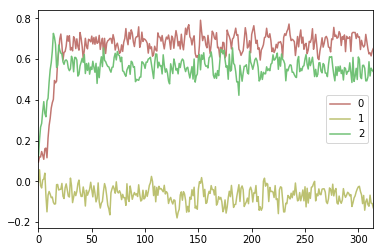

In [62]:
tr = pd.DataFrame(samples )
pd.DataFrame(samples ).plot()

In [63]:
pd.DataFrame(samples ).tail(1000).mean()

0    0.659249
1   -0.067341
2    0.555572
dtype: float64

In [25]:
beta_0,beta_1,beta_2

(0.7, -0.1, 0.5)

In [27]:
pd.DataFrame(samples).iloc[7000:,:] .mean()

0    0.275114
1   -0.037402
2    0.254855
dtype: float64

In [28]:
m.params

0    0.688665
1   -0.064216
2    0.572844
dtype: float64

In [29]:
pd.DataFrame(samples).apply(lambda x: x.autocorr())

0    0.911809
1    0.573672
2    0.863918
dtype: float64

KeyboardInterrupt: 

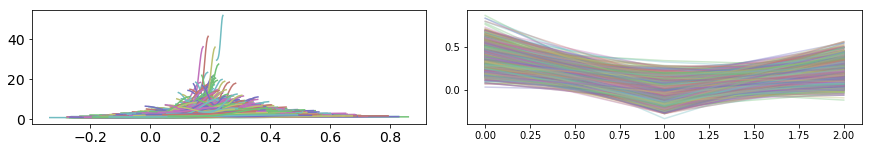

In [19]:
import arviz as az
g=az.plot_trace( np.array(samples))

g=az.plot_trace(np.expand_dims( np.array(samples), axis=0),)
g=az.plot_autocorr(np.expand_dims( np.array(samples), axis=0))

In [ ]:
data = az.convert_to_inference_data(np.expand_dims( np.array(samples), axis=0))


In [ ]:
import arviz as az

az.style.use('arviz-darkgrid')

data = az.convert_to_inference_data(np.expand_dims( np.array(samples), axis=0))
az.plot_ppc(data, alpha=0.3, kind='cumulative', figsize=(12, 6), textsize=14)

In [30]:
import emcee


In [31]:
emcee.__version__

'3.0rc2'

In [32]:
ndim, nwalkers = 3, 100
pos = [np.array([0,0,0]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

import emcee
def lnprob(theta,r,y,X):
    lp = lnprior(theta,theta*0,np.eye(len(theta)))
    mu = np.exp(X@theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnposterior(theta,1,mu,y,theta*0,np.eye(len(theta)))

sampler = emcee.EnsembleSampler(nwalkers, ndim,lnprob,args=(r,y ,X.values ))
chains = sampler.run_mcmc(pos, 5000,**{"progress":True}) 

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:55<00:00, 43.42it/s]


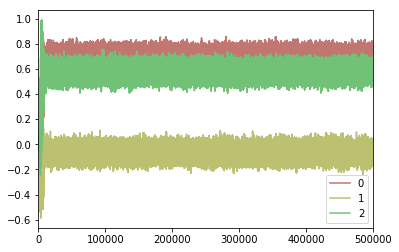

In [35]:
pd.DataFrame(sampler.flatchain).plot()

In [36]:
pd.DataFrame(sampler.flatchain).mean()

0    0.679604
1   -0.064547
2    0.566771
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002176E545E80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002176E771828>]], dtype=object)

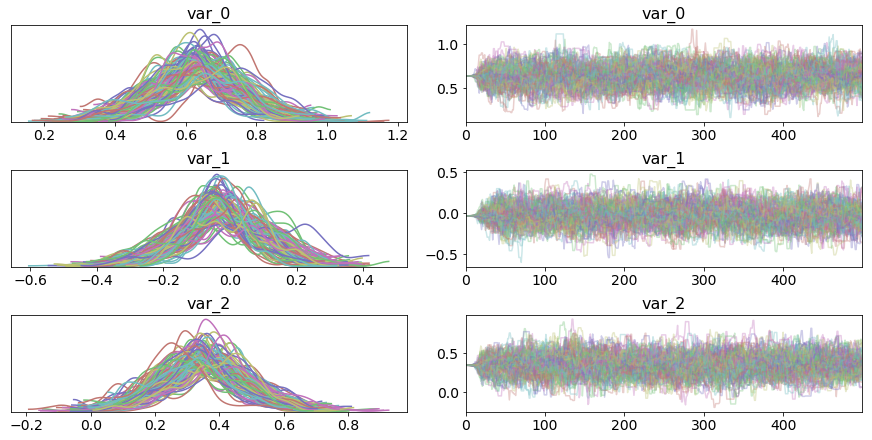

In [24]:
import arviz as az
emcee_data = az.from_emcee(sampler)
az.plot_trace(emcee_data)

In [ ]:
import corner
fig = corner.corner(samples  )
fig.savefig("triangle.png")